## Data Viz
---
Create a COCO dataset from labeled images.

**Tasks**
1. 

**Assumptions**
1. Image sets are located in datatsets/train-test-val/annotations 
2. 26 annotations for each image with image name at root
3.  

In [1]:
import os
import json
# import glob
from PIL import Image
import time
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Write json to file
def WriteJSON(obj,filename):
    try:
        with open(filename, 'w') as outfile:
            obj_json = json.dumps(obj, sort_keys=True, indent=4,default=str)
            outfile.write(obj_json)
    except Exception as e:
        print(e)
        print('File not written.')

# Read and return json object from file. If none, return empty object.
def ReadJSON(filename):
    try: 
        with open(filename, 'r') as infile:
            obj = json.load(infile)
    except Exception as e:
        print(e)
        obj = [] 
    return obj

### Draw Annotations

In [3]:
def DrawBoxes(ax,anno):
    
    # Draw boxes
    if len(anno['bbox']) == 4:
#         print('Drawing bbox')
        rect = plt.Rectangle((anno['bbox'][0], anno['bbox'][1]),anno['bbox'][2], anno['bbox'][3], color = (anno['color'][0]/255,anno['color'][1]/255,anno['color'][2]/255), alpha=.2)
        ax.add_artist(rect)
        
    return ax

In [4]:
def DrawMask(ax,mask,c):
    
    # Create np array
    a = np.array(mask)
    # Reshape
    a = a.reshape(int(len(mask)/2),2)
    mask = a

    # Get X/Y list pairs
    x = [i[0] for i in mask]
    y = [i[1] for i in mask]
    
    # Create patch
    poly = plt.Polygon(mask,closed=True,color=c,alpha=.3)
    ax.add_artist(poly)
    
    return ax

def DrawMasks(ax,anno):
#     print('Drawing Masks')
    
    # normalize color
    c = anno['color']
    c = [i/255 for i in c]
    
    # Draw masks
    for i,mask in enumerate(anno['segmentation']):
#         if i == 0:
        ax = DrawMask(ax,mask,c)
            
    return ax

In [5]:
def DrawKP(ax,curr):
    circle1 = plt.Circle((curr[0], curr[1]),3.0, color=curr[2])
    ax.add_artist(circle1)
    return ax

def DrawLine(ax,prev,curr):
    if curr[2] == [0,0,0] or prev[2] == [0,0,0]:
        ax.plot([prev[0],curr[0]],[prev[1],curr[1]],color=[0,0,0]) #curr[2]
    else: 
        ax.plot([prev[0],curr[0]],[prev[1],curr[1]],color=curr[2])
    return ax
    
def DrawKeypoints(ax,anno,cat):
#     print('Drawing keypoints')
    
    # Get kp names/nums/connections
    kp = anno['keypoints']
    kp_names = cat['keypoints']
    skeleton = cat['skeleton']
    
    # Turn list to np array to get tuples
    a = np.array(kp)
    a = a.reshape(6,3)
    prev = []
    for x in range(0, a.shape[0]):
        
        # Convert each iter back to list
        pnt = list(a[x])
#         print(pnt)
    
        # Manage color - white/black or cat color
        c = pnt[2]
        if c == 1: 
            c = (0,0,0)
        elif c == 0:
            c = (255,255,255)
        else:
            c = anno['color']
        c = [i/255 for i in c]
        # Add color back in
        pnt[2] = c
        
        # draw each keypoint
        ax = DrawKP(ax,pnt)
        
        # Draw line after first pnt
        initVal = 0
        if len(prev)> 0 and prev[0] > initVal and prev[1] > initVal and pnt[0] > initVal and pnt[1] > initVal:
            ax = DrawLine(ax,prev,pnt)
    
        # Keep prev pnt
        prev = pnt
        
    return ax

In [6]:
def DrawAnnotations(path, categories, annotations,ANNOTATION_FILE):
    
#     print(path)
    # Open image
    img = Image.open(path)

    # Set anno file
#     annotations_file = "/".join(path.split('/')[:-1])+'/test_region_data.json'
#     print(annotations_file)

    # Get image name
    img_name = path.split('/')[-1]

    # red=front, green=middle, blue=rear
    colors = [(255,0,0),(0,255,0),(0,0,255)]
    
    # Read anno file
    obj = ReadJSON(ANNOTATION_FILE)
    
    # Check if image is in file
    imgExists = False
    # Get all paths
    for i,imgName in enumerate(obj['images']):
        if img_name == imgName['file_name']:
            imgExists = True
            img_id = obj['images'][i]['id']
            break
    if not imgExists:
        print("Could not find image in annotations file.")
    else:

        # Get catids from image
        cat_ids = obj['images'][i]['category_ids']
        
        # Define each image 
        figsize = [25,25]
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot()

        # Draw annos for categories. Add each anno to ax.
        for i,cat_id in enumerate(cat_ids):
            for j,anno in enumerate(obj['annotations']):
                # Match on image name and cat ID
                if img_id == anno['image_id'] and cat_id == anno['category_id'] and cat_id in categories:
                    print(img_id)
                    if 1 in annotations:
                        ax = DrawBoxes(ax,anno)
                    if 2 in annotations:
                        ax = DrawMasks(ax,anno)
                    if 3 in annotations:
                        ax = DrawKeypoints(ax,anno,obj['categories'][cat_id-1])
                    
        # Image info does not print with img
        print('Image name:',img_name)
        print("Image ID:",img_id)
        print('category IDS:',cat_ids)
        print('---------------------')
        
        # Draw image
        ax.imshow(img)

### Read Region JSON Data

In [26]:
# paths= [paths[0]]
# paths

paths = ["/Users/jessedecker/projects/rail_segmentation/datasets/pantograph/train/swin_to_padd_frame_67368.jpg"]
paths

['/Users/jessedecker/projects/rail_segmentation/datasets/pantograph/train/swin_to_padd_frame_67368.jpg']

In [28]:
'''
Check current number saved images in train/val/test
'''

folders = ['train','test','val']

# Set path to root directory for saving images
# PATH_TO_JSON_FILE = '/home/jupyter/GCP_Test/datasets/pantograph/'+folders[0]+'/region_data.json'
PATH_TO_JSON_FILE = '/Users/jessedecker/projects/rail_segmentation/datasets/pantograph/'+folders[0]+'/region_data.json'
print('Opening JSON at:',PATH_TO_JSON_FILE)

obj = ReadJSON(PATH_TO_JSON_FILE)

images = obj['images']
print('Number of images:',len(images))

annotations = obj['annotations']
print('Number of annotations:',len(annotations))

categories = obj['categories']

#Load paths
paths = [i['path'] for i in images]

Opening JSON at: /Users/jessedecker/projects/rail_segmentation/datasets/pantograph/train/region_data.json
Number of images: 232
Number of annotations: 690


In [29]:
paths = paths[-2:]
paths

['/Users/jessedecker/projects/rail_segmentation/datasets/pantograph/train/padd_to_swin_frame_106090.jpg',
 '/Users/jessedecker/projects/rail_segmentation/datasets/pantograph/train/padd_to_swin_frame_102221.jpg']

230
230
230
Image name: padd_to_swin_frame_106090.jpg
Image ID: 230
category IDS: [1, 2, 3]
---------------------
231
231
231
Image name: padd_to_swin_frame_102221.jpg
Image ID: 231
category IDS: [1, 2, 3]
---------------------


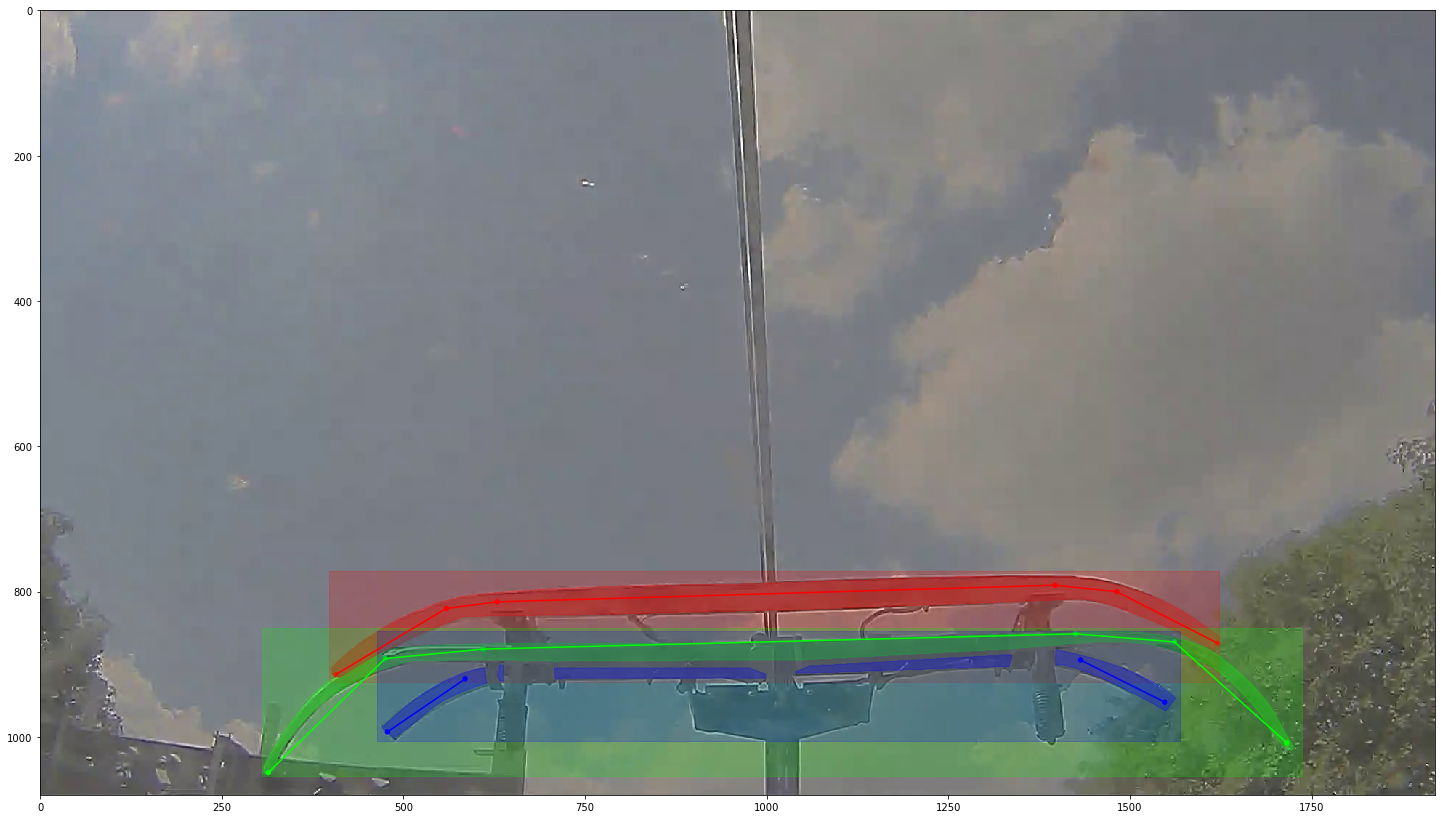

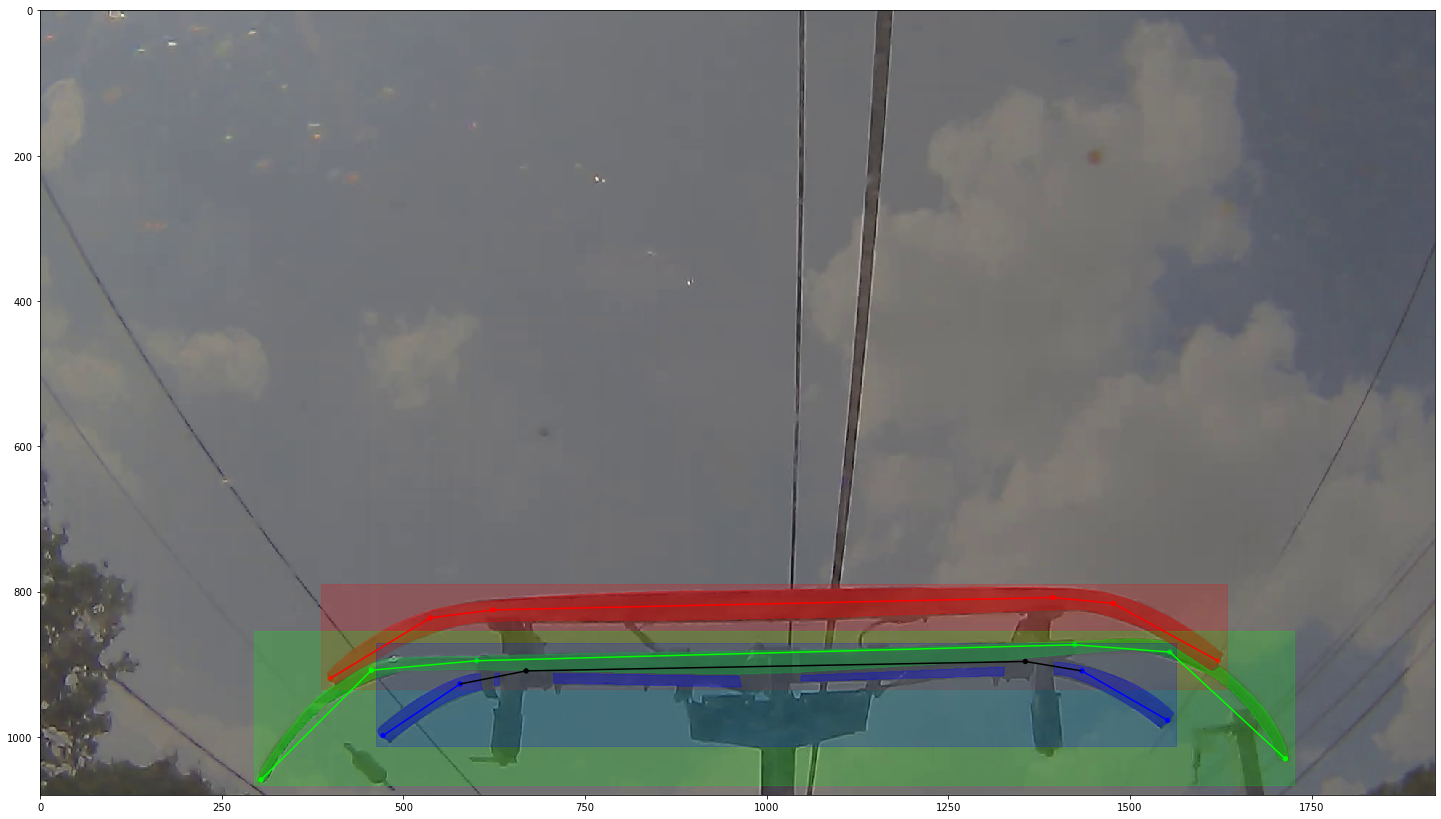

In [30]:
# 1=front_bar,2=middle_bar, 3=rear_bar
categories = [1,2,3]

# 1=bbox,2=masks, 3=keypoints
annotations = [1,2,3]

# for path in [paths]:
for path in paths:
    DrawAnnotations(path, categories, annotations,PATH_TO_JSON_FILE)

In [30]:
'''
Delete bitmap images
'''

for path in paths:
    
    file = path.split("/")[-1][:-4]
    folder = "/".join(path.split("/")[:-1])
    folder += '/annotations/'
    
    print(file,folder)

swin_to_padd_frame_42132 /Users/jessedecker/projects/rail_segmentation/datasets/pantograph/train/annotations/
swin_to_padd_frame_36415 /Users/jessedecker/projects/rail_segmentation/datasets/pantograph/train/annotations/
swin_to_padd_frame_47849 /Users/jessedecker/projects/rail_segmentation/datasets/pantograph/train/annotations/
swin_to_padd_frame_270812 /Users/jessedecker/projects/rail_segmentation/datasets/pantograph/train/annotations/
swin_to_padd_frame_24981 /Users/jessedecker/projects/rail_segmentation/datasets/pantograph/train/annotations/
swin_to_padd_frame_30698 /Users/jessedecker/projects/rail_segmentation/datasets/pantograph/train/annotations/
swin_to_padd_frame_242227 /Users/jessedecker/projects/rail_segmentation/datasets/pantograph/train/annotations/
swin_to_padd_frame_247944 /Users/jessedecker/projects/rail_segmentation/datasets/pantograph/train/annotations/
swin_to_padd_frame_259378 /Users/jessedecker/projects/rail_segmentation/datasets/pantograph/train/annotations/
swin_t

In [31]:
def GetAllBitmaps(img_folder):
    return [img for img in glob.glob(img_folder+'/*.bmp')]